In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from flaml import AutoML

from imblearn.over_sampling import SMOTENC
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, confusion_matrix

from utils import preprocess_data
from custom_metrics import get_DI_cats, balanced_accuracy_FLAML

/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/Users/emiliolr/miniforge3/envs/life-hunting/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


**There are really a few question marks here for me...**
1. Can we train a model to discern between the cases of local extirpation, abundance decrease, no change, and abundance increase?
2. Can we train two seperate models to predict the continuous responses for abundance increases and decreases?
3. When we compose these three models, does it perform fairly well in predicting RRs? What are its distribution qualities, compared to our other two-stage hurdle models?

In [2]:
# Set random seed
np.random.seed(1693)

In [3]:
# Read dataset
data = pd.read_csv('/Users/emiliolr/Google Drive/My Drive/LIFE/datasets/derived_datasets/benitez_lopez2019_recreated/benitez_lopez2019_recreated_extended.csv')

In [4]:
# Train test split - just random for now!
train_pct = 0.8

idxs = [i for i in range(len(data))]
train_idxs = list(np.random.choice(idxs, replace = False, size = int(train_pct * len(idxs))))
test_idxs = [i for i in idxs if i not in train_idxs]

train_test_idxs = {'train' : train_idxs,
                   'test' : test_idxs}

In [5]:
# Apply preprocessing
governance_cols = ['Corruption', 'Government_Effectiveness', 'Political_Stability', 'Regulation', 
                   'Rule_of_Law', 'Accountability']

pp_data = preprocess_data(data, include_indicators = False, include_categorical = False,
                          standardize = True, log_trans_cont = False, polynomial_features = 0,
                          embeddings_to_use = None, embeddings_args = None, train_test_idxs = train_test_idxs,
                          pca_save_fp = None, pca_cols = governance_cols, dataset = 'mammals_recreated')
pp_data.head()

,Body_Mass,Stunting_Pct,Literacy_Rate,Dist_Settlement_KM,Travel_Time_Large,Livestock_Biomass,Population_Density,Percent_Settlement_50km,PC_0,Protected_Area,Response_Ratio
0,-0.252507,-0.38111,-0.032217,-0.52269,-0.114407,-0.353364,-0.195078,-0.470403,0.465455,1,0.377193
1,4.526840,-0.38111,-0.032217,-0.52269,-0.114407,-0.353364,-0.195078,-0.470403,0.465455,1,0.865690
2,-0.252507,-0.38111,-0.032217,-0.52269,-0.114407,-0.353364,-0.195078,-0.470403,0.465455,1,0.833333
3,4.526840,-0.38111,-0.032217,-0.52269,-0.114407,-0.353364,-0.195078,-0.470403,0.465455,1,0.900862
4,-0.252507,-0.38111,-0.032217,-0.52269,-0.114407,-0.353364,-0.195078,-0.470403,0.465455,1,0.956140


In [6]:
# Generate DI categories for model to predict
cat_encoding = {'extirpated' : 0,
                'decrease' : 1, 
                'no change' : 2,
                'increase' : 3}
cat_decoding = {v : k for k, v in cat_encoding.items()}

pp_data['DI_cat'] = get_DI_cats(pp_data['Response_Ratio'], neighborhood = 0)
pp_data['DI_cat'] = pp_data['DI_cat'].apply(lambda x: cat_encoding[x])
pp_data['DI_cat'].value_counts()

DI_cat
1    1198
2    1020
3     655
0     408
Name: count, dtype: int64

In [7]:
# Split up training/testing sets
predictors = [c for c in pp_data.columns if c not in ['Response_Ratio', 'DI_cat']]
response = 'DI_cat'

X_train, y_train = pp_data.iloc[train_idxs][predictors], pp_data.iloc[train_idxs][response]
X_test, y_test = pp_data.iloc[test_idxs][predictors], pp_data.iloc[test_idxs][response]

In [8]:
# Resampling the dataset using SMOTE
categorical_features = ['Protected_Area']
smote = SMOTENC(categorical_features = categorical_features, random_state = 1693)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [9]:
# Setting up the model
time_budget_mins = 5

model = AutoML()
model_settings = {'time_budget' : time_budget_mins * 60,  # in seconds
                  'metric' : balanced_accuracy_FLAML,
                  'task' : 'classification',
                  'log_file_name' : 'scratch_dir/flaml_three_part_model.txt',
                  'seed' : 1693,
                  'estimator_list' : ['rf', 'xgboost'],
                  'early_stop' : True,
                  'verbose' : 5,
                  'keep_search_state' : True,
                  'eval_method' : 'cv'}

In [10]:
# Training the model
model.fit(X_train, y_train, **model_settings)

[flaml.automl.logger: 09-17 23:31:53] {1680} INFO - task = classification
[flaml.automl.logger: 09-17 23:31:53] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 09-17 23:31:53] {1789} INFO - Minimizing error metric: customized metric
[flaml.automl.logger: 09-17 23:31:53] {1901} INFO - List of ML learners in AutoML Run: ['rf', 'xgboost']
[flaml.automl.logger: 09-17 23:31:53] {2219} INFO - iteration 0, current learner rf
[flaml.tune.tune: 09-17 23:31:53] {811} INFO - trial 1 config: {'n_estimators': 4, 'max_features': 0.3162277660168379, 'max_leaves': 4, 'criterion': 'gini'}
[flaml.automl.logger: 09-17 23:31:54] {2345} INFO - Estimated sufficient time budget=1835s. Estimated necessary time budget=2s.
[flaml.automl.logger: 09-17 23:31:54] {2392} INFO -  at 0.2s,	estimator rf's best error=0.6899,	best estimator rf's best error=0.6899
[flaml.automl.logger: 09-17 23:31:54] {2219} INFO - iteration 1, current learner xgboost
[flaml.tune.tune: 09-17 23:31:54] {811} INFO - trial 1 confi

In [11]:
# Checking which model was chosen + the hyperparams
print(model.best_estimator)
print(model.best_config)

xgboost
{'n_estimators': 28, 'max_leaves': 411, 'min_child_weight': 0.5544253180325318, 'learning_rate': 0.06871488494917231, 'subsample': 0.939515769407492, 'colsample_bylevel': 0.7016198708383087, 'colsample_bytree': 0.9394523172330307, 'reg_alpha': 0.020371772527445774, 'reg_lambda': 0.01265024743294022}


Balanced accuracy: 57.69%


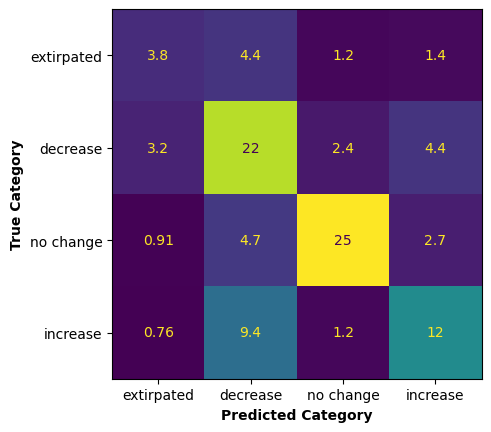

In [13]:
# Some basic model evaluation
y_pred = model.predict(X_test)

#  get balanced accuracy
ba = balanced_accuracy_score(y_test, y_pred)
print(f'Balanced accuracy: {round(ba * 100, 2)}%')

#  display confusion matrix
class_names = [cat_decoding[c] for c in model.classes_]

cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
cm = (cm / len(y_test)) * 100
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names)

disp.plot(colorbar = False)

plt.ylabel('True Category', weight = 'bold')
plt.xlabel('Predicted Category', weight = 'bold')

plt.show()

In [27]:
# Checking per-class balanced accuracy scores
for c in model.classes_:
    y_pred_c = (y_pred == c).astype(int)
    y_test_c = (y_test == c).astype(int)
    
    ba = balanced_accuracy_score(y_test_c, y_pred_c)
    print(f'BA for class "{cat_decoding[c]}" is {round(ba * 100, 2)}%')

BA for class "extirpated" is 64.88%
BA for class "decrease" is 70.73%
BA for class "no change" is 83.74%
BA for class "increase" is 70.37%


In [36]:
# Comparing to a random guesser, as a baseline
probs = y_train.value_counts().sort_index().values / len(y_train)

bas = []
for i in range(1000):
    y_guess = np.random.choice(model.classes_, size = len(y_test), replace = True, p = probs)
    ba = balanced_accuracy_score(y_test, y_guess)
    bas.append(ba)

print(f'Random guessing (based on class probs.) achieves BA of {round(np.mean(bas) * 100, 2)}% over 1000 runs')

Random guessing (based on class probs.) achieves BA of 24.99% over 1000 runs


In [39]:
# Same thing but on a class-per-class basis, just to check what our baseline is...
bas = {0 : [], 1 : [], 2 : [], 3 : []}
for i in range(1000):
    y_guess = np.random.choice(model.classes_, size = len(y_test), replace = True, p = probs)
    
    for c in model.classes_:
        y_guess_c = (y_guess == c).astype(int)
        y_test_c = (y_test == c).astype(int)
        
        ba = balanced_accuracy_score(y_test_c, y_guess_c)
        bas[c].append(ba)

for c in model.classes_:
    print(f'Random guessing achieves BA of {round(np.mean(bas[c]) * 100, 2)}% over 1000 runs for class "{cat_decoding[c]}"')

Random guessing achieves BA of 50.0% over 1000 runs for class "extirpated"
Random guessing achieves BA of 49.96% over 1000 runs for class "decrease"
Random guessing achieves BA of 50.05% over 1000 runs for class "no change"
Random guessing achieves BA of 49.94% over 1000 runs for class "increase"
